***1.Импортируем необходимые библиотеки***

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import category_encoders as ce #для кодирования признаков
from collections import Counter
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

#DATA_DIR = '/kaggle/input/sf-booking/'
#df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
#df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
#sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

df_train = pd.read_csv('data/hotels_train.csv') #датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv')
sample_submission = pd.read_csv('data/submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [7]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [8]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\Pelte\AppData\Local\Temp\ipykernel_3836\447817491.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


Предварительно ознакомимся с полученными данными.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

<AxesSubplot:>

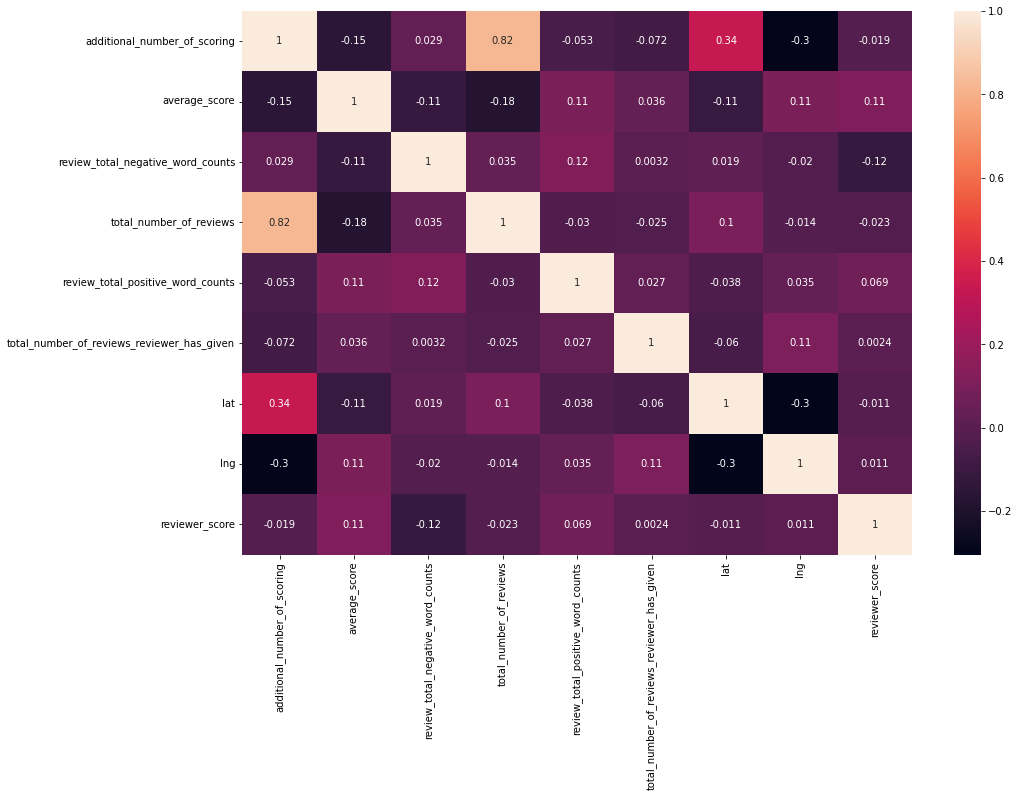

In [10]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

Обработает полученный датасет от дубликатов (в кагл работаем с полным набором данных)

In [11]:
#Удалим дубликаты
print(f'Всего записей: {data.shape[0]}')

data_dedupped = data.drop_duplicates()
print(f'Результирующее число записей: {data_dedupped.shape[0]}')

Всего записей: 515738
Результирующее число записей: 515402


***2. EDA***

Далее перейдем к разведывательному анализу данных :
1. Определим числовые и не числовые признаки.
2. Обработаем каждый не числовой признак по очереди
3. Создадим новые признаки 
4. Обработаем пропуски
5. Очистим от ненужных признаков


Отбор числовых колонок 

In [12]:
data_numeric = data_dedupped.select_dtypes(include=[np.number])
numeric_cols = data_numeric.columns.values
print(numeric_cols)

['additional_number_of_scoring' 'average_score'
 'review_total_negative_word_counts' 'total_number_of_reviews'
 'review_total_positive_word_counts'
 'total_number_of_reviews_reviewer_has_given' 'lat' 'lng' 'sample'
 'reviewer_score']


Отбор не числовых колонок

In [13]:
data_non_numeric = data_dedupped.select_dtypes(exclude=[np.number])
non_numeric_cols = data_non_numeric.columns.values
print(non_numeric_cols)

['hotel_address' 'review_date' 'hotel_name' 'reviewer_nationality'
 'negative_review' 'positive_review' 'tags' 'days_since_review']


В нашем датасете 10 числовых признаков, 8 признаков типа обджект.
Для машинного обучения необходимы только числовые значения, поэтому по порядку разберемся с категориальными.Далее будем разбираться с пропусками.

**Обработка категориальных призанков**

***2.1. Признак 'hotel_address'***

In [14]:
data['hotel_address'].head()

0                   Via Senigallia 6 20161 Milan Italy
1    Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...
2          Mallorca 251 Eixample 08008 Barcelona Spain
3    Piazza Della Repubblica 17 Central Station 201...
4    Singel 303 309 Amsterdam City Center 1012 WJ A...
Name: hotel_address, dtype: object

В данном признаке есть много информации, попробуем достать :
1. город 
2. страну 
3. далее создадим их как отдельные признаки.

In [15]:
#обрабатываем по сравнению и индексации
#Признак city
data['city'] = data['hotel_address'].apply(lambda x : 'London' if x.split()[-1] == 'Kingdom' else x.split()[-2])
#Признак country
data['country'] = data['hotel_address'].apply(lambda x : 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

display(data['country'].value_counts(), data['city'].value_counts())

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country, dtype: int64

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

Кодируем признаки и удаляем не нужный(исходный)

In [16]:
encoder = ce.OneHotEncoder(cols=['country'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['country'])
data = pd.concat([data, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['city'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['city'])
data = pd.concat([data, type_bin], axis=1)

data = data.drop(['hotel_address'],axis=1)

Вывод: из 1 признака получили 2 более значимых, далее их закодировали

In [17]:
#data = data.drop(['city'],axis=1) не удалем (пригодится позже)
#data = data.drop(['country'],axis=1) 

***2.2 Признак 'review_date'***

In [18]:
data['review_date'].head()

0     7/21/2017
1    12/12/2016
2    11/26/2015
3    10/17/2015
4     5/16/2016
Name: review_date, dtype: object

Для начала преобразуем к формату дейттайм. Далее сегментируем на:
1. месяцы
2. годы

In [19]:
data['review_date'] = pd.to_datetime(data['review_date'])

data['month'] = data['review_date'].dt.month.astype(int)
data['year'] = data['review_date'].dt.year.astype(int)
#Кодировать не будем , поскольку стали численными признаками

***2.3 Признак 'hotel_name'***

In [20]:
data['hotel_name'].head()
data['hotel_name'].nunique()
data = data.drop(['hotel_name'],axis=1)

*Не давал попокоя мне этот признак. Нашел TargetEncoder для мультиклассовых целевых признаков. Но реализовать не вышло. Прошу совета , нужно ли это ?*
*Поскольку реализовать не вышло , удалил.*

In [21]:
#from category_encoders import TargetEncoder
#TARGET = 'reviewer_score'
#encoder = ce.TargetEncoder(cols=['hotel_name']) # указываем столбец для кодирования
#type_bin = encoder.fit_transform(data['hotel_name'], data[TARGET])
#data = pd.concat([data, type_bin], axis=1)

#data = data.drop(['hotel_name'],axis=1)

***2.4 Признак reviewer_nationality***

In [22]:
data['reviewer_nationality'].head()
top_nationalities= data['reviewer_nationality'].value_counts().nlargest(20).index #список наиболее часто встречаемых
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top_nationalities else 'Other')

display(data['reviewer_nationality'].head(10))
# кодируем признак национальности с помощью LabelEncoder
data['reviewer_nationality'] = LabelEncoder().fit_transform(data['reviewer_nationality'])

0               United Kingdom 
1                      Belgium 
2                         Other
3     United States of America 
4               United Kingdom 
5                         Other
6               United Kingdom 
7                  Netherlands 
8                      Ireland 
9                       Canada 
Name: reviewer_nationality, dtype: object

***2.5 Признак negative_review***

In [23]:
data['negative_review'].head()
data['negative_review'].value_counts().nlargest(20)


No Negative         127890
 Nothing             14295
 Nothing              4236
 nothing              2225
 N A                  1037
 None                  984
                       849
 N a                   509
 Breakfast             407
 Small room            373
 Location              368
 Everything            326
 All good              318
 Nothing really        316
 none                  302
 nothing               283
 No complaints         274
 Price                 260
 Nothing really        254
 Nil                   247
Name: negative_review, dtype: int64

*Видим , что в негативные отзывы попали "No negative, Nothing, N A, All good, none, Nothing really",  исправляем это. Приведем все к одному регистру и переберем.*

In [24]:
data['negative_review'] = data['negative_review'].apply(lambda x : x.lower().strip())
data['negative_review'].value_counts().nlargest(20)

no negative                127890
nothing                     21185
n a                          1815
none                         1501
                              849
nothing really                656
small room                    570
all good                      545
breakfast                     545
no complaints                 523
location                      502
nothing at all                467
everything                    420
nothing to dislike            373
price                         348
nil                           332
small rooms                   307
everything was perfect        276
na                            272
can t think of anything       250
Name: negative_review, dtype: int64

In [25]:
false_neg = ['no negative','nothing','n a','none','','all good','nothing really','na','nothing to dislike']

data['new_negative_review'] = data['negative_review'].apply(lambda x : 0 if x in false_neg else 1)#вручную кодируем признак

data['new_negative_review'].value_counts()

1    360652
0    155086
Name: new_negative_review, dtype: int64

In [26]:
#убираем исходный
data = data.drop(['negative_review'], axis=1)

***2.6 Признак positive_review***

Схема действий аналогична 

In [27]:
data['positive_review'].head()

0     Hotel was great clean friendly staff free bre...
1                                          No Positive
2                           Nice welcoming and service
3     Everything including the nice upgrade The Hot...
4                      Lovely hotel v welcoming staff 
Name: positive_review, dtype: object

In [28]:
data['positive_review'] = data['positive_review'].apply(lambda x : x.lower().strip())
data['positive_review'].value_counts().nlargest(20)

no positive                   35946
location                      11945
everything                     3314
nothing                        1731
great location                 1687
the location                   1606
good location                  1496
breakfast                       795
friendly staff                  733
excellent location              639
staff                           553
location and staff              452
location staff                  432
location location location      345
location was great              328
good breakfast                  316
everything was perfect          316
location was good               312
comfy bed                       303
perfect location                287
Name: positive_review, dtype: int64

In [29]:
false_pos = ['no positive','nothing']
data['new_positive_review'] = data['positive_review'].apply(lambda x : 0 if x in false_pos else 1)
data['new_positive_review'].value_counts()

1    478061
0     37677
Name: new_positive_review, dtype: int64

In [30]:
data = data.drop(['positive_review'], axis=1)

***2.7 Признак tags***

In [31]:
data['tags'].head()

0    [' Leisure trip ', ' Couple ', ' Double Room '...
1    [' Leisure trip ', ' Group ', ' Triple Room ',...
2    [' Business trip ', ' Solo traveler ', ' Twin ...
3    [' Leisure trip ', ' Couple ', ' Ambassador Ju...
4    [' Business trip ', ' Solo traveler ', ' Class...
Name: tags, dtype: object

In [32]:
#Конвертируем теги в списки.
def rev_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res
data['tags'] = data['tags'].apply(rev_func)
data['tags']

0         [Leisure trip, Couple, Double Room, Stayed 2 n...
1         [Leisure trip, Group, Triple Room, Stayed 1 ni...
2         [Business trip, Solo traveler, Twin Room, Stay...
3         [Leisure trip, Couple, Ambassador Junior Suite...
4         [Business trip, Solo traveler, Classic Double ...
                                ...                        
515733    [Leisure trip, Group, Club Double or Twin Room...
515734    [Leisure trip, Couple, Standard Double Room, S...
515735    [Business trip, Solo traveler, Single Room, St...
515736    [Leisure trip, Solo traveler, Deluxe Double Ro...
515737    [Leisure trip, Couple, Bunk Bed Room, Stayed 4...
Name: tags, Length: 515738, dtype: object

По тегам я бы разделил признаки на несколько категорий:
1. кол-во ночей
2. Тип номера 
3. Кол-во людей в заезде 
4. тип путешествия

In [33]:
#Создадим функцию по отбору кол-ва ночей, прописав пропуски 1 ночью
def get_stay(x):
    for tag in x:
        words = tag.split()
        if words[0] =='Stayed':
            return int(words[1])
    return np.NaN

data['number of nights'] = data['tags'].apply(get_stay)
data['number of nights'].fillna(1, inplace=True)

In [34]:
boundary = data.shape[0] * 0.03  # 3% граница отбора признаков (почему именно 3%, потому что посчитал , что так больше необходимым признаков попадут)
c = Counter(tag for row in data['tags'] for tag in row)
frequent_tags_count = dict(filter(lambda x: x[1] > boundary, c.items()))
print('Наиболее часто встрчающиеся тэги и кол-во:')
frequent_tags_count

Наиболее часто встрчающиеся тэги и кол-во:


{'Leisure trip': 417778,
 'Couple': 252294,
 'Double Room': 35207,
 'Stayed 2 nights': 133937,
 'Group': 65392,
 'Stayed 1 night': 193645,
 'Business trip': 82939,
 'Solo traveler': 108545,
 'Submitted from a mobile device': 307640,
 'Standard Double or Twin Room': 17483,
 'Stayed 3 nights': 95821,
 'Double or Twin Room': 22393,
 'Superior Double Room': 31393,
 'Stayed 4 nights': 47817,
 'Standard Double Room': 32248,
 'Stayed 5 nights': 20845,
 'Family with young children': 61015,
 'Family with older children': 26349,
 'Classic Double Room': 16989,
 'Deluxe Double Room': 24823}

In [35]:
#фильтруем данные так , что б они соответсвовали двум условиям
frequent_tags = list(dict(filter(lambda x: 
    x[1]>boundary and x[0].split()[0]!='Stayed', 
    frequent_tags_count.items())).keys())
frequent_tags

['Leisure trip',
 'Couple',
 'Double Room',
 'Group',
 'Business trip',
 'Solo traveler',
 'Submitted from a mobile device',
 'Standard Double or Twin Room',
 'Double or Twin Room',
 'Superior Double Room',
 'Standard Double Room',
 'Family with young children',
 'Family with older children',
 'Classic Double Room',
 'Deluxe Double Room']

In [36]:
for tag in frequent_tags:
    data[tag] = data['tags'].apply(lambda x: 1 if tag in x else 0)

In [37]:
data = data.drop(['tags'],axis=1)

Проверяем оставшиеся не числовые признаки

In [38]:
data_non_numeric = data.select_dtypes(exclude=[np.number])
non_numeric_cols = data_non_numeric.columns.values
print(non_numeric_cols)

['review_date' 'days_since_review' 'city' 'country']


***2.8 Признак days_since_review***

In [39]:
data['days_since_review']

0         13 days
1         234 day
2         616 day
3         656 day
4         444 day
           ...   
515733    106 day
515734    171 day
515735    543 day
515736    74 days
515737    363 day
Name: days_since_review, Length: 515738, dtype: object

In [40]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split(' ')[0])
data['days_since_review'] = data['days_since_review'].astype(int)

In [41]:
data.nunique(dropna=False)

additional_number_of_scoring                   480
review_date                                    731
average_score                                   34
reviewer_nationality                            21
review_total_negative_word_counts              402
total_number_of_reviews                       1142
review_total_positive_word_counts              365
total_number_of_reviews_reviewer_has_given     198
days_since_review                              731
lat                                           1473
lng                                           1473
sample                                           2
reviewer_score                                  38
city                                             6
country                                          6
country_Italy                                    2
country_Netherlands                              2
country_Spain                                    2
country_United Kingdom                           2
country_France                 

In [42]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
#object_columns = [s for s in data.columns if data[s].dtypes == 'object']
#data.drop(object_columns, axis = 1, inplace=True)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 47 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515738 non-null  int64         
 1   review_date                                 515738 non-null  datetime64[ns]
 2   average_score                               515738 non-null  float64       
 3   reviewer_nationality                        515738 non-null  int32         
 4   review_total_negative_word_counts           515738 non-null  int64         
 5   total_number_of_reviews                     515738 non-null  int64         
 6   review_total_positive_word_counts           515738 non-null  int64         
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64         
 8   days_since_review                           515738 non-null  int32        

***2.9 Проверяем на пропуски***

In [44]:
data.isnull().sum()

additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
reviewer_nationality                             0
review_total_negative_word_counts                0
total_number_of_reviews                          0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
city                                             0
country                                          0
country_Italy                                    0
country_Netherlands                              0
country_Spain                                    0
country_United Kingdom                           0
country_France                 

In [45]:
data['lat'] = data['lat'].fillna(
    data.groupby(['city'])['lat'].transform(lambda x: x.mode()[0])
)
data['lng'] = data['lng'].fillna(
    data.groupby(['city'])['lng'].transform(lambda x: x.mode()[0])
)

Удалеяем все оставшиеся не числовые признаки 

In [46]:
data = data.drop(['city'],axis=1)
data = data.drop(['country'],axis=1)
data = data.drop(['review_date'], axis=1)

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 44 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   reviewer_nationality                        515738 non-null  int32  
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   review_total_positive_word_counts           515738 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 7   days_since_review                           515738 non-null  int32  
 8   lat                                         515738 non-null  float64
 9   lng                                         515738 non-null  float64
 

Посчитал , что в данном случае нормализация данных не нужна. Поскольку отсутвует большая разница в цифрах

***3. Мультиколиниарность ***

In [48]:
data.columns

Index(['additional_number_of_scoring', 'average_score', 'reviewer_nationality',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'lat', 'lng', 'sample', 'reviewer_score', 'country_Italy',
       'country_Netherlands', 'country_Spain', 'country_United Kingdom',
       'country_France', 'country_Austria', 'city_Milan', 'city_Amsterdam',
       'city_Barcelona', 'city_London', 'city_Paris', 'city_Vienna', 'month',
       'year', 'new_negative_review', 'new_positive_review',
       'number of nights', 'Leisure trip', 'Couple', 'Double Room', 'Group',
       'Business trip', 'Solo traveler', 'Submitted from a mobile device',
       'Standard Double or Twin Room', 'Double or Twin Room',
       'Superior Double Room', 'Standard Double Room',
       'Family with young children', 'Family with older children',
       'Classic Double Room', 'Deluxe Dou

In [49]:
# непрерывные признаки
num_cols = ['number of nights', 
       'Leisure trip', 
       'Couple', 
       'Double Room', 
       'Group',
       'Business trip', 
       'Solo traveler', 
       'Submitted from a mobile device',
       'Standard Double or Twin Room', 
       'Double or Twin Room',
       'Superior Double Room', 
       'Standard Double Room',
       'Family with young children', 
       'Family with older children',
       'Classic Double Room', 
       'Deluxe Double Room',
       'lat', 
       'lng', 
       'sample', 
       'reviewer_score',
       'review_total_negative_word_counts', 
       'total_number_of_reviews',
       'review_total_positive_word_counts', 
       'total_number_of_reviews_reviewer_has_given', 
       'days_since_review',
       'average_score',
       'additional_number_of_scoring']

# категориальные признаки 17
cat_cols = ['country_Italy',
       'country_Netherlands', 
       'country_Spain', 
       'country_United Kingdom',
       'country_France', 
       'country_Austria', 
       'city_Milan', 
       'city_Amsterdam',
       'city_Barcelona', 
       'city_London', 
       'city_Paris', 
       'city_Vienna',
       'month',
       'year',
       'reviewer_nationality',
       'new_negative_review',
       'new_positive_review']

In [50]:
def show_corr_heatmap(columns_list, title, method):
    """Построения корреляционной диаграммы"""
    fig_, ax_ = plt.subplots(figsize=(15, 12))
    corr = data[columns_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='viridis',
                fmt='.1g')
    ax_.set_title(title, fontsize=18)
    plt.show()

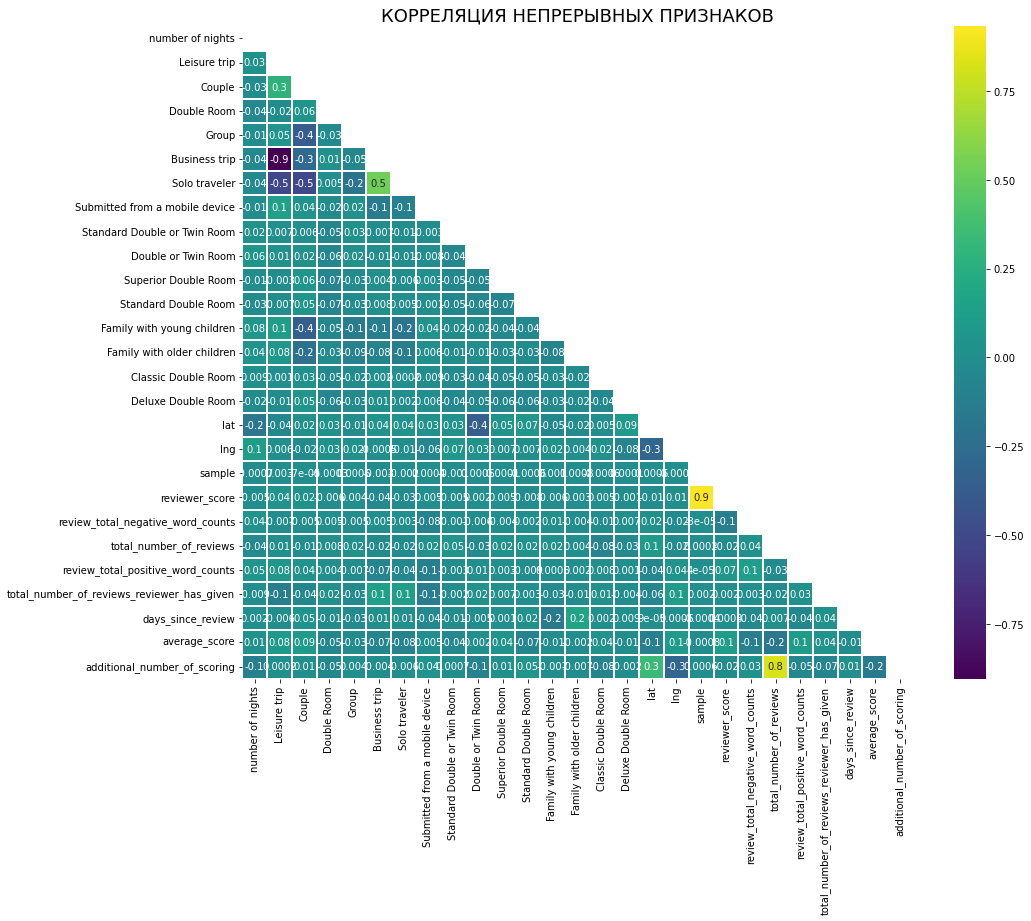

In [51]:
show_corr_heatmap(num_cols, 'КОРРЕЛЯЦИЯ НЕПРЕРЫВНЫХ ПРИЗНАКОВ', method='pearson');

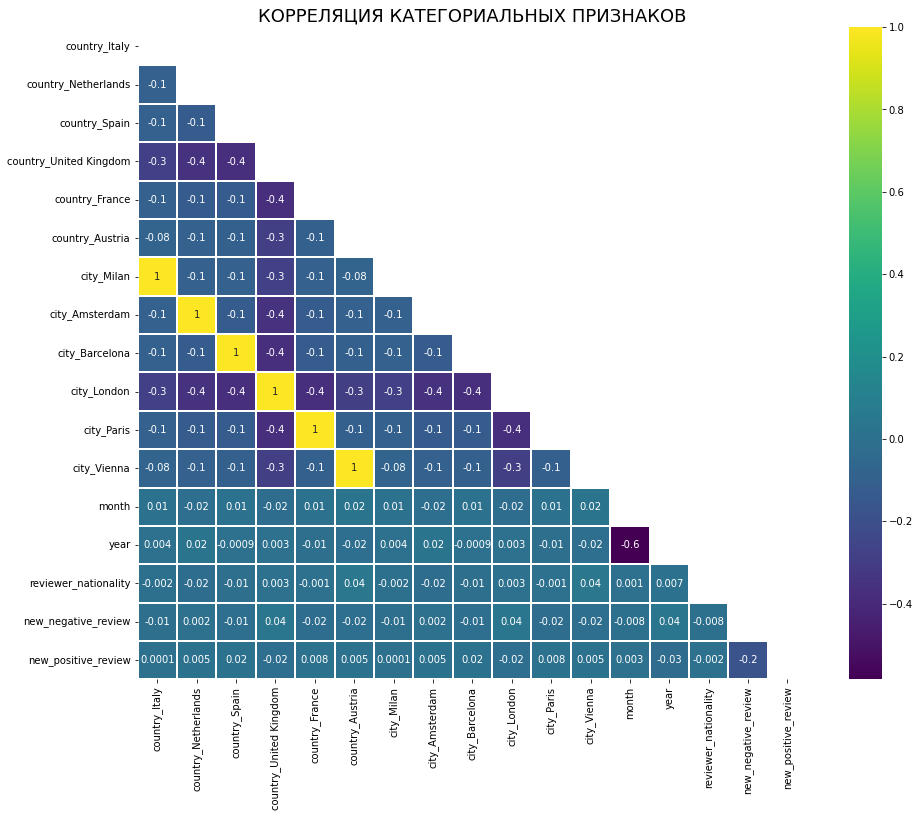

In [52]:
# строю диаграмму для категориальных признаков:
show_corr_heatmap(
    cat_cols, 
    'КОРРЕЛЯЦИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ', 
    method='spearman'
)

Удалим признаки, которые могут привести к мультиколлинеарности

In [53]:
data.drop(['total_number_of_reviews'], axis = 1, inplace=True)
data.drop(['Business trip'], axis = 1, inplace=True)

data.drop(['city_Milan'], axis = 1, inplace=True)
data.drop(['city_Amsterdam'], axis = 1, inplace=True)
data.drop(['city_Barcelona'], axis = 1, inplace=True)
data.drop(['city_London'], axis = 1, inplace=True)
data.drop(['city_Paris'], axis = 1, inplace=True)
data.drop(['city_Vienna'], axis = 1, inplace=True)


print(f'Текущее получившееся количество признаков: {len(data.columns)}')
print('(включая столбец "Sample" и целевой столбец)')

Текущее получившееся количество признаков: 36
(включая столбец "Sample" и целевой столбец)


In [54]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [55]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [56]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 35), (386803, 35), (386803, 34), (309442, 34), (77361, 34))

In [57]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [58]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [59]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished


In [60]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает оказывает среднюю абсолютную процентную ошибку..
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1333060436913412


<AxesSubplot:>

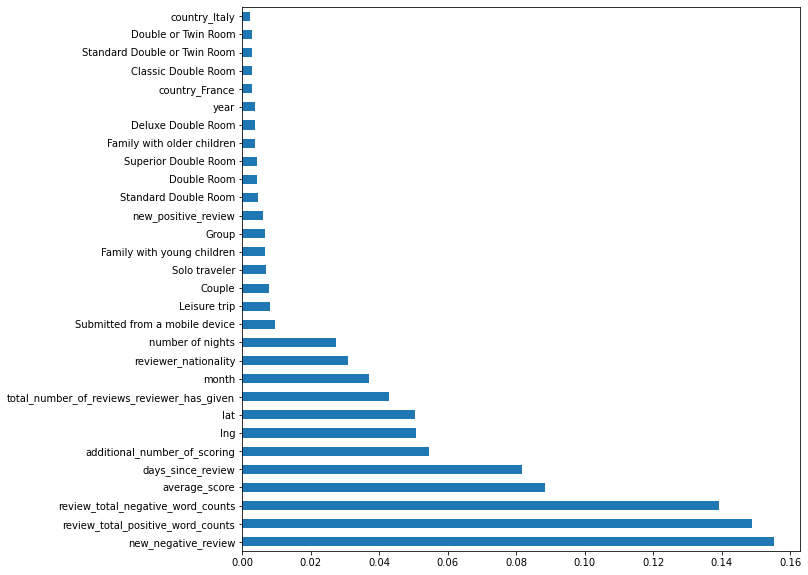

In [61]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

In [62]:
test_data.sample(10)

,additional_number_of_scoring,average_score,reviewer_nationality,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,...,Solo traveler,Submitted from a mobile device,Standard Double or Twin Room,Double or Twin Room,Superior Double Room,Standard Double Room,Family with young children,Family with older children,Classic Double Room,Deluxe Double Room
107002,160,9.0,20,24,0,1,496,48.854787,2.308482,0.0,...,0,1,0,0,0,0,0,0,0,0
1981,2623,8.7,18,0,36,1,534,51.500961,-0.116591,0.0,...,0,1,0,0,0,0,0,0,0,0
19540,950,8.6,18,17,0,4,515,51.506472,-0.071689,0.0,...,0,0,0,0,0,0,0,0,0,0
15091,76,8.2,19,17,15,1,420,48.865473,2.329293,0.0,...,0,0,0,0,0,0,0,0,0,0
74941,908,8.5,20,9,10,7,185,51.514400,-0.156551,0.0,...,0,0,0,0,0,0,1,0,0,0
108655,482,9.0,20,7,30,16,17,52.377743,4.897057,0.0,...,0,1,0,0,0,0,0,0,0,0
13936,21,9.8,13,77,14,3,170,48.867947,2.328959,0.0,...,0,1,0,0,0,0,0,0,0,0
19819,269,8.0,0,8,8,5,309,41.387348,2.160399,0.0,...,0,1,0,1,0,0,0,0,0,0
127773,321,8.6,7,8,10,13,376,48.231911,16.412949,0.0,...,0,1,0,0,0,0,1,0,0,1
110329,84,8.7,9,36,26,35,267,48.221770,16.357874,0.0,...,1,0,0,0,0,0,0,0,0,0


In [63]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [64]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [65]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.0s finished


In [66]:
predict_submission

array([8.689, 6.997, 7.994, ..., 7.954, 9.357, 7.173])

In [67]:
list(sample_submission)

['reviewer_score', 'id']

In [68]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission

,reviewer_score,id
0,8.689,488440
1,6.997,274649
2,7.994,374688
3,9.621,404352
4,9.488,451596
...,...,...
128930,8.520,495812
128931,7.948,315577
128932,7.954,511968
128933,9.357,303386
